# Image classification with CNN
Reference: https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212

In [1]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation
import os
import torch # PyTorch package
from PIL import Image
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

os.chdir("../")

### 1. Load data

In [2]:
# define classes
CLASSES = [
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck',
]

In [3]:
# identify class (idx) from filename
def get_idx(fname):
    if "(" not in fname:
        return 0
    return int(fname.split("(")[1].split(")")[0]) - 1

In [4]:
# set training data type
train_data_type = "REAL"

# load training data
train_dir = f"data/cifake/train/{train_data_type}"
train_fnames = os.listdir(train_dir)
train_imgs, train_labels = [], []
for fname in train_fnames:
    img = Image.open(f"{train_dir}/{fname}")
    train_imgs.append(np.array(img))
    train_labels.append(get_idx(fname))
train_imgs = np.stack(train_imgs)
train_labels = np.array(train_labels)
print(train_imgs.shape, train_labels.shape)

(50000, 32, 32, 3) (50000,)


In [5]:
# set params
BATCH_SIZE = 40

# set up train dataloader
train_imgs = torch.Tensor(train_imgs)
train_labels = torch.Tensor(train_labels)
train_data = TensorDataset(train_imgs, train_labels)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
next_imgs, next_labels = next(iter(train_dataloader))
print(next_imgs.shape, next_labels.shape)

torch.Size([40, 32, 32, 3]) torch.Size([40])


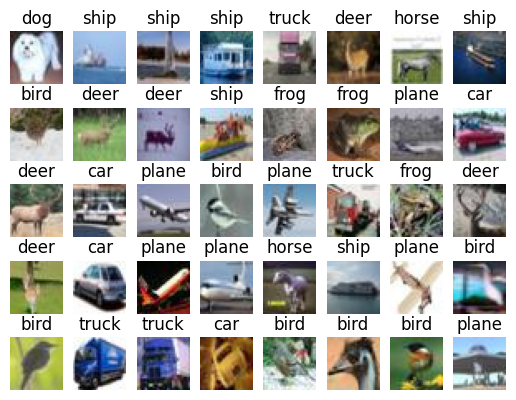

In [6]:
# display batch of data
fig = plt.figure()
for i, img in enumerate(next_imgs):
    fig.add_subplot(5, 8, i+1)
    plt.imshow(img.long())
    plt.title(CLASSES[int(next_labels[i])])
    plt.axis("off")

In [7]:
# load testing data
test_dir = f"data/cifake/test/REAL"
test_fnames = os.listdir(test_dir)
test_imgs, test_labels = [], []
for fname in test_fnames:
    img = Image.open(f"{test_dir}/{fname}")
    test_imgs.append(np.array(img))
    test_labels.append(get_idx(fname))
test_imgs = np.stack(test_imgs)
test_labels = np.array(test_labels)
print(test_imgs.shape, test_labels.shape)

(10000, 32, 32, 3) (10000,)


In [8]:
# set up test dataloader
test_imgs = torch.Tensor(test_imgs)
test_labels = torch.Tensor(test_labels)
test_data = TensorDataset(test_imgs, test_labels)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

### 2. Define the CNN

In [9]:
class ImageClassifier(nn.Module):
    ''' Models a simple CNN image classifier'''
	
    def __init__(self):
        ''' initialize the network '''
        super(ImageClassifier, self).__init__()
	    # 3 input image channel, 6 output channels, 
	    # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 32, 5)
	    # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5) 
        self.fc1 = nn.Linear(64 * 5 * 5, 256) # 5x5 from image dimension
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ImageClassifier()
print(model)

ImageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
# use gpu
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

### 3. Define a loss function and optimizer

In [11]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# oprimizer
optimizer = optim.Adam(model.parameters(), lr = 0.00005)

### 4. Train the model

In [12]:
metrics = {}
for epoch in range(20):  # loop over the dataset multiple times
    
    print(f"Epoch {epoch + 1}:")
    
    train_loss, train_acc = 0, 0
    for i, (imgs, labels) in enumerate(train_dataloader):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(imgs.permute(0, 3, 1, 2))
        loss = loss_fn(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # get statistics
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs) == labels.long()).float().sum().item()
        
    train_loss = round(train_loss / len(train_dataloader), 4)
    train_acc = round(train_acc / len(train_dataloader), 4)
    print(f"Train loss = {train_loss}; acc = {train_acc}.")
    
    test_loss, test_acc = 0, 0
    for i, (imgs, labels) in enumerate(test_dataloader):
        
        outputs = model(imgs.permute(0, 3, 1, 2))
        loss = loss_fn(outputs, labels.long())
        test_loss += loss.item()
        test_acc += (torch.argmax(outputs) == labels.long()).float().sum().item()
    
    test_loss = round(test_loss / len(test_dataloader), 4)
    test_acc = round(test_acc / len(test_dataloader), 4)
    print(f"Test loss = {test_loss}; acc = {test_acc}.")
    
    if epoch == 0 or test_loss < min([m[2] for m in metrics.values()]) or test_acc > max([m[3] for m in metrics.values()]):
        model_save_path = f"models/simple_CNN/{train_data_type}/checkpoint_{epoch:02}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Checkpoint saved at {model_save_path}.")
    
    print("\n")
    
    metrics[epoch] = (train_loss, train_acc, test_loss, test_acc)

Epoch 1:
Train loss = 1.6325; acc = 0.1416.
Test loss = 1.4043; acc = 0.16.
Checkpoint saved at models/simple_CNN/REAL/checkpoint_00.pth.


Epoch 2:
Train loss = 1.2942; acc = 0.1248.
Test loss = 1.2104; acc = 0.108.
Checkpoint saved at models/simple_CNN/REAL/checkpoint_01.pth.


Epoch 3:
Train loss = 1.1416; acc = 0.0816.
Test loss = 1.1776; acc = 0.156.
Checkpoint saved at models/simple_CNN/REAL/checkpoint_02.pth.


Epoch 4:
Train loss = 1.0318; acc = 0.0792.
Test loss = 1.0767; acc = 0.096.
Checkpoint saved at models/simple_CNN/REAL/checkpoint_03.pth.


Epoch 5:
Train loss = 0.948; acc = 0.1536.
Test loss = 1.045; acc = 0.1.
Checkpoint saved at models/simple_CNN/REAL/checkpoint_04.pth.


Epoch 6:
Train loss = 0.8758; acc = 0.1112.
Test loss = 1.0593; acc = 0.18.
Checkpoint saved at models/simple_CNN/REAL/checkpoint_05.pth.


Epoch 7:
Train loss = 0.8062; acc = 0.0968.
Test loss = 1.022; acc = 0.172.
Checkpoint saved at models/simple_CNN/REAL/checkpoint_06.pth.


Epoch 8:
Train loss 

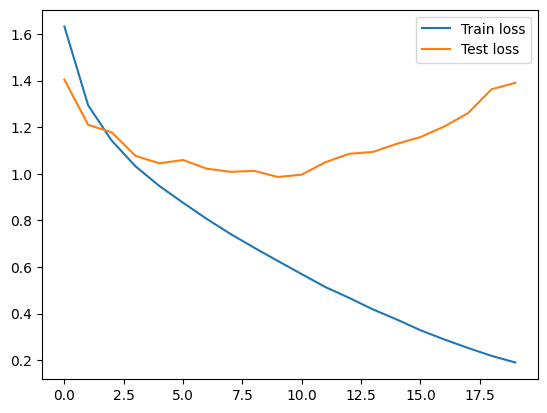

In [13]:
plt.plot([x[0] for x in metrics.values()], label="Train loss")
plt.plot([x[2] for x in metrics.values()], label="Test loss")
plt.legend()